In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio

from matplotlib.patches import Rectangle
from tensorflow.keras.preprocessing import image
from glob import glob
from skimage.transform import resize
from skimage.util import img_as_ubyte

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import binary_crossentropy

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

File ‘charmander-tight.png’ already there; not retrieving.



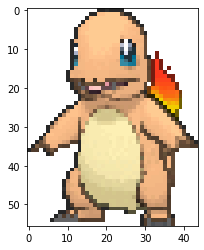

In [3]:
ch = imageio.imread('charmander-tight.png')
plt.imshow(ch)
plt.show()

In [4]:
type(ch)

imageio.core.util.Array

In [5]:
ch.shape

(56, 44, 4)

In [6]:
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip

File ‘backgrounds.zip’ already there; not retrieving.



In [7]:
!unzip -n backgrounds.zip

Archive:  backgrounds.zip


In [8]:
backgrounds = []

background_files = glob('backgrounds/*.jpg')
for background_file in background_files:
  bg = np.array(image.load_img(background_file))
  backgrounds.append(bg)

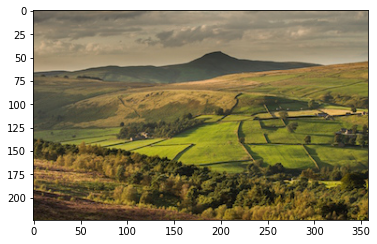

In [9]:
plt.imshow(backgrounds[2])
plt.show()

In [10]:
IMG_SIZE = 200
ch = np.array(ch)
CH_H, CH_W, _ = ch.shape

In [28]:
def image_generator_bg(batch_size=5):
  while True:
      X = np.zeros((batch_size, IMG_SIZE, IMG_SIZE, 3))
      Y = np.zeros((batch_size, 5))

      for i in range(batch_size):
        # randomly select a background
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w, _ = bg.shape
        rnd_x = np.random.randint(bg_h - IMG_SIZE)
        rnd_y = np.random.randint(bg_w - IMG_SIZE)
        X[i] = bg[rnd_x:rnd_x+IMG_SIZE, rnd_y:rnd_y+IMG_SIZE]

        # object probably appears
        appear = (np.random.random() < 0.5)
        if appear:

          # resize Charmander
          global ch
          scale = 0.5 + np.random.random()
          CH_H_new = int(CH_H * scale)
          CH_W_new = int(CH_W * scale)
          ch_new = img_as_ubyte(resize(ch, (CH_H_new, CH_W_new)))

          # flip Charmander with probability
          if np.random.random() < 0.5:
            ch_new = np.fliplr(ch_new)

          # locate a region for Charmander randomly
          row0 = np.random.randint(IMG_SIZE - CH_H_new)
          col0 = np.random.randint(IMG_SIZE - CH_W_new)
          row1 = row0 + CH_H_new
          col1 = col0 + CH_W_new

          # process Charmander and background so that we get the desired 
          # result when adding them together
          mask = (ch_new[:, :, 3] == 0) # find where the pokemon is 0
          bg_slice = X[i, row0:row1, col0:col1, :] # where we want to place pokemon
          bg_slice = np.expand_dims(mask, -1) * bg_slice # (h, w, 1) * (h, w, 3)
          bg_slice += ch_new[:, :, :3] # "add" pokemon to the slice
          X[i, row0:row1, col0:col1, :] = bg_slice # put the slice back

          # make targets by normalization 
          Y[i, 0] = row0 / IMG_SIZE
          Y[i, 1] = col0 / IMG_SIZE
          Y[i, 2] = (row1 - row0) / IMG_SIZE
          Y[i, 3] = (col1 - col0) / IMG_SIZE

        Y[i, 4] = appear

      yield X / 255.0, Y

<function print>

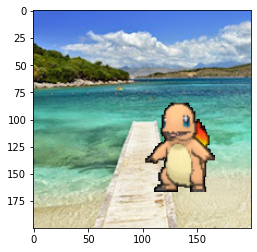

In [29]:
X, _ = next(image_generator_bg())
plt.imshow(X[1])
print

In [30]:
def custom_loss(y_true, y_pred):
  bce1 = binary_crossentropy(y_true[:, :-1], y_pred[:, :-1])
  bce2 = binary_crossentropy(y_true[:, -1], y_pred[:, -1])

  return 2* y_true[:, -1] * bce1 + 0.5 * bce2 

In [31]:
def make_model():
  vgg = tf.keras.applications.VGG16(
      input_shape=[IMG_SIZE, IMG_SIZE, 3], 
      include_top=False, 
      weights='imagenet')
  x = Flatten()(vgg.output)
  x = Dense(5, activation='sigmoid')(x)
  model = Model(vgg.input, x)

  model.compile(loss=custom_loss, optimizer=Adam(lr=0.001))

  return model

In [32]:
model = make_model()
model.fit(
    image_generator_bg(),
    steps_per_epoch=100,
    epochs=8
)

Epoch 1/8
100/100 [==============================] - 9s 94ms/step - loss: 1.1008
Epoch 2/8
100/100 [==============================] - 10s 95ms/step - loss: 0.8093
Epoch 3/8
100/100 [==============================] - 9s 93ms/step - loss: 0.5694
Epoch 4/8
100/100 [==============================] - 9s 92ms/step - loss: 0.5913
Epoch 5/8
100/100 [==============================] - 9s 91ms/step - loss: 0.5756
Epoch 6/8
100/100 [==============================] - 9s 92ms/step - loss: 0.5435
Epoch 7/8
100/100 [==============================] - 9s 91ms/step - loss: 0.5455
Epoch 8/8
100/100 [==============================] - 9s 92ms/step - loss: 0.5442


In [33]:
def pokemon_prediction_bg():
  # randomly select a background
  bg_idx = np.random.choice(len(backgrounds))
  bg = backgrounds[bg_idx]
  bg_h, bg_w, _ = bg.shape
  rnd_x = np.random.randint(bg_h - IMG_SIZE)
  rnd_y = np.random.randint(bg_w - IMG_SIZE)
  x = bg[rnd_x:rnd_x+IMG_SIZE, rnd_y:rnd_y+IMG_SIZE].copy()

  # object probably appears
  appear = (np.random.random() < 0.5)
  if appear:

    # resize Charmander
    global ch
    scale = 0.5 + np.random.random()
    CH_H_new = int(CH_H * scale)
    CH_W_new = int(CH_W * scale)
    ch_new = img_as_ubyte(resize(ch, (CH_H_new, CH_W_new)))

    # flip Charmander with probability
    if np.random.random() < 0.5:
      ch_new = np.fliplr(ch_new)

    # locate a region for Charmander randomly
    row0 = np.random.randint(IMG_SIZE - CH_H_new)
    col0 = np.random.randint(IMG_SIZE - CH_W_new)
    row1 = row0 + CH_H_new
    col1 = col0 + CH_W_new

    # process Charmander and background so that we get the desired 
    # result when adding them together
    mask = (ch_new[:, :, 3] == 0) # find where the pokemon is 0
    bg_slice = x[row0:row1, col0:col1, :] # where we want to place pokemon
    bg_slice = np.expand_dims(mask, -1) * bg_slice # (h, w, 1) * (h, w, 3)
    bg_slice += ch_new[:, :, :3] # "add" pokemon to the slice
    x[row0:row1, col0:col1, :] = bg_slice # put the slice back

    print([row0, col0, row1, col1])

  # predict
  X = np.expand_dims(x, 0) / 255.0
  p = model.predict(X)[0]
  print((p * IMG_SIZE).astype(int).tolist())
  
  # plot
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))

  # draw predicted bounding box if there is any
  if p[4] > 0.5:
    rect = Rectangle(
        (p[1]*IMG_SIZE, p[0]*IMG_SIZE),
        p[3]*IMG_SIZE, 
        p[2]*IMG_SIZE, 
        linewidth=1, 
        edgecolor='r', 
        facecolor='none')
    ax.add_patch(rect)
  else:
    print("No object exists")

  print(p[4])
  plt.show()

[71, 47, 38, 28, 0]
No object exists
0.0031139737


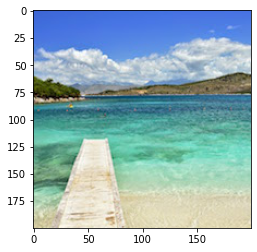

In [42]:
pokemon_prediction_bg()